# set path

In [48]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)

    #unpack zipped file (reading files from drive is slow)
    os.chdir('/content')
    import shutil
    shutil.unpack_archive("/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess.zip", "./")
    rootpath = '/content/freya_postprocess/'

except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Imports

In [49]:
import torch

In [50]:
import torchvision

In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import time

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle('/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)



cuda
Tesla T4


# Data loaders and transformers

In [52]:
mass_bins = np.linspace(11, 14.7, 11) ## number of classes = len(mass_bins) - 1 = 10
mass_bins_nums = np.histogram(subhalos_df['logSubhaloMass'], bins=mass_bins)[0]
mass_bins_weights = np.max(mass_bins_nums)/mass_bins_nums
mass_bins_weights = mass_bins_weights / np.sum(mass_bins_weights)
mass_bins_weights = torch.tensor(mass_bins_weights, dtype=torch.float32)

class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)  # Define mass_bins globally or pass as argument

    def __init__(self, root_dir, subhalos_df):
        self.root_dir = root_dir
        self.subhalos_df = subhalos_df
        self.files = glob(root_dir + '*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]
        self.loaded_data = self.preload_data()

    def preload_data(self):
        #lesson learned: loading all data at once is faster than loading it on the fly. Before that all files were loaded for each index separately and with the inference time of 0.1 sec the data loading was 30 sec
        data_dict = {}
        for file in self.files:
            halo_id = int(file.split('_')[-1].split('.')[0])
            data = np.load(file)
            data_dict[halo_id] = {
                'map_2d_xy': data['map_2d_xy'],
                'map_2d_xz': data['map_2d_xz'],
                'map_2d_yz': data['map_2d_yz'],
            }
        return data_dict

    def __len__(self):
        return len(self.halos_ids)

    def select_random_projection(self):
        return np.random.choice(['xy', 'xz', 'yz'])

    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        data = self.loaded_data[halo_id]

        # Select a random projection
        selected_projection = self.select_random_projection()

        if selected_projection == 'xy':
            selected_data = np.expand_dims(data['map_2d_xy'], axis=0)
        elif selected_projection == 'xz':
            selected_data = np.expand_dims(data['map_2d_xz'], axis=0)
        elif selected_projection == 'yz':
            selected_data = np.expand_dims(data['map_2d_yz'], axis=0)


        label_mass = self.subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins) - 1
        label = (label_mass, label_class, halo_id)


        return selected_data, label


dataset = HaloDataset(root_dir = rootpath, subhalos_df=subhalos_df)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [53]:
class FillInfWithMin:
    def __init__(self, fill_value=-np.inf):
        self.fill_value = fill_value

    def __call__(self, batch):
        # Create a mask to identify non-inf values
        mask = batch != self.fill_value

        # Compute the minimum value per image, ignoring -inf values
        min_per_image = torch.where(mask, batch, torch.inf).view(batch.size(0), -1).min(dim=1)[0]

        # Reshape min_per_image to match the dimensions of batch
        min_per_image = min_per_image.view(batch.size(0), 1, 1, 1)

        # Replace -inf values with the corresponding minimum values
        filled_batch = torch.where(batch == self.fill_value, min_per_image, batch)

        return filled_batch


img_transform= transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    transforms.RandomRotation(degrees=180, fill=-np.inf),
    FillInfWithMin(fill_value=-np.inf)  # Custom transform to fill -inf with min per image
])


In [54]:
def time_data_loading(dataloader, model = None, transform = None):
    t = time.time()
    n = len(dataloader)
    for i, (projections, batch_label) in enumerate(dataloader):

        if transform is not None:
            input_img = transform(projections)
        else:
            input_img = projections

        input_img = input_img.to(device)

        label = batch_label[1].to(device)

        if model is not None:
            model(input_img)

    print(f'{n} batches loaded in {time.time() - t:.2f} sec. {batch_size=}; inference={model is not None}; transform={transform is not None}')



# Initialize dataset and dataloader

if device=='cpu':
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
    print('dataloader on gpu')
    batch_size = 512
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 2)

#time_data_loading(dataloader)
#time_data_loading(dataloader, transform=img_transform)

dataloader on gpu


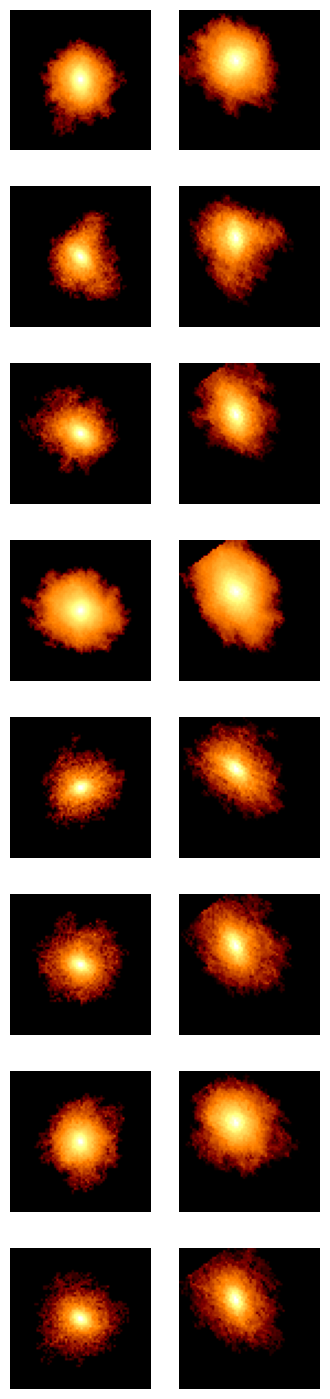

In [55]:
batch_test_data, _ = next(iter(dataloader))
batch_test_data_trans = img_transform(batch_test_data)

fig, axs = plt.subplots(8, 2, figsize=(4, 18))

for i in range(8):
    axs[i, 0].imshow(batch_test_data[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 1].imshow(batch_test_data_trans[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')


# Classification model for mass bin

## Model

In [56]:
class ClassificationNN(nn.Module):

    "Encoder network"
    def __init__(self):
        super(ClassificationNN, self).__init__()

        image_channels = 1
        self.cnn = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            #nn.Linear(64, 64),
            #nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        logits =  self.cnn(x)
        #make always class 0 for debugging, 9.1 on the first element and 0.1 on the rest
        #logits = torch.zeros_like(logits)+0.1
        #logits[:, 0] = 9.0
        return logits

def classification_train_step(
        epoch,
        model,
        criterion,
        optimizer,
        scheduler,
        dataloader,
        dataloader_val,
        history=None,
        device='cpu',
        ):

    model.train()

    running_loss = 0.0

    for i, (batch_data, batch_label) in enumerate(dataloader):

        batch_label = batch_label[1].to(device)

        view1 = img_transform(batch_data)
        view1 = view1.to(device)

        pred_class = model(view1)
        loss = criterion(pred_class, batch_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()

    running_loss /= len(dataloader)
    #print(f'Epoch {epoch}, loss: {running_loss}')

    if history is not None:
        history['loss'].append(running_loss)

    if dataloader_val is not None:
        model.eval()
        running_loss_val = 0.0

        for i, (batch_data, batch_label) in enumerate(dataloader_val):

            batch_label = batch_label[1].to(device)
            batch_data = batch_data.to(device)

            pred_class = model(batch_data)
            loss = criterion(pred_class, batch_label)

            running_loss_val += loss.item()

        running_loss_val /= len(dataloader_val)
        #print(f'Epoch {epoch}, val loss: {running_loss_val}')
    else:
        running_loss_val = None

    if history is not None:
        history['val_loss'].append(running_loss_val)

    return running_loss, running_loss_val


def classification_train(epochs,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 dataloader,
                 dataloader_val,
                 history=None,
                 device = 'cpu'):

    pbar = tqdm(range(epochs))

    history = {'loss': [], 'val_loss': []} if history is None else history

    try:
        for epoch in pbar:
            loss, loss_val = classification_train_step(
                epoch,
                model,
                criterion,
                optimizer,
                scheduler,
                dataloader,
                dataloader_val,
                history=history,
                device=device
            )
            pbar.set_postfix({'loss': loss, 'val_loss': loss_val})

    except KeyboardInterrupt:
        print('Interrupted')

    return history

In [39]:
print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

lr = 5e-3

classification_model = ClassificationNN().to(device)

criterion = nn.CrossEntropyLoss(weight=mass_bins_weights.to(device)).to(device)
optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


Batch size: 512


In [61]:
#debug shapes
batch_test_data, _ = next(iter(dataloader))


output = classification_model(batch_test_data.to(device))

#print(f'Output shape: {output}')
print(f'Output shape: {output.shape}')


time_data_loading(dataloader)
time_data_loading(dataloader, classification_model)
time_data_loading(dataloader, classification_model, img_transform)

Output shape: torch.Size([512, 10])
33 batches loaded in 3.53 sec. batch_size=512; inference=False; transform=False
33 batches loaded in 3.89 sec. batch_size=512; inference=True; transform=False
33 batches loaded in 8.31 sec. batch_size=512; inference=True; transform=True


## Training

In [43]:
n_epochs = 50

history = classification_train(n_epochs,
                       classification_model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=train_loader,
                        dataloader_val=val_loader,
                        device=device)



100%|██████████| 50/50 [03:47<00:00,  4.55s/it, loss=2.16, val_loss=2.21]


{'loss': [2.2789703249931335, 2.2551460385322573, 2.2196776390075685, 2.203040099143982, 2.190230059623718, 2.1778558015823366, 2.171073651313782, 2.164714515209198, 2.171203446388245, 2.155694341659546, 2.1580536365509033, 2.167850708961487, 2.1700173735618593, 2.1607636213302612, 2.158208799362183, 2.1689055442810057, 2.1630062222480775, 2.1645889282226562, 2.164770209789276, 2.1625377893447877, 2.166747009754181, 2.1696141719818116, 2.1623541474342347, 2.165043020248413, 2.1678908586502077, 2.1721163988113403, 2.1677441716194155, 2.161338818073273, 2.1641871094703675, 2.164207339286804, 2.1642295002937315, 2.167702615261078, 2.1738734245300293, 2.1608426570892334, 2.161358082294464, 2.1597477078437803, 2.1633076906204223, 2.1669886469841004, 2.160800886154175, 2.1630061745643614, 2.1677059173583983, 2.156968688964844, 2.162333345413208, 2.170118737220764, 2.1640121698379517, 2.1575025081634522, 2.166441285610199, 2.168605387210846, 2.1659804224967956, 2.163248658180237], 'val_loss':

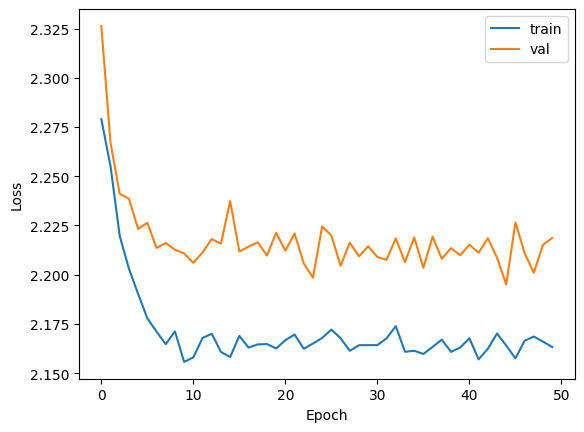

In [42]:
print(history)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


{'loss': [2.1656073570251464, 2.1666162967681886, 2.1615225315093993, 2.1663954854011536, 2.15912321805954, 2.1738027691841126, 2.1621629118919374, 2.168140780925751, 2.164386284351349, 2.1622279286384583, 2.169199001789093, 2.163181722164154, 2.1667276263237, 2.1688012719154357, 2.1622416734695435, 2.167728900909424, 2.1692073345184326, 2.167950654029846, 2.1831590294837953, 2.156809651851654, 2.1665072679519652, 2.161088836193085, 2.1715254902839662, 2.1697035849094393, 2.170612943172455, 2.1598541855812075, 2.155003023147583, 2.163286805152893, 2.1607531905174255, 2.1822975277900696, 2.1685662984848024, 2.1684250116348265, 2.16521018743515, 2.167683255672455, 2.171258735656738, 2.1715546011924745, 2.1673012256622313, 2.166962242126465, 2.169348216056824, 2.167307949066162, 2.1696886301040648, 2.1661009430885314, 2.1717211961746217, 2.1675533771514894, 2.162083828449249, 2.1666398882865905, 2.1616556107997895, 2.1614521145820618, 2.1640758156776427, 2.164074957370758], 'val_loss': [2

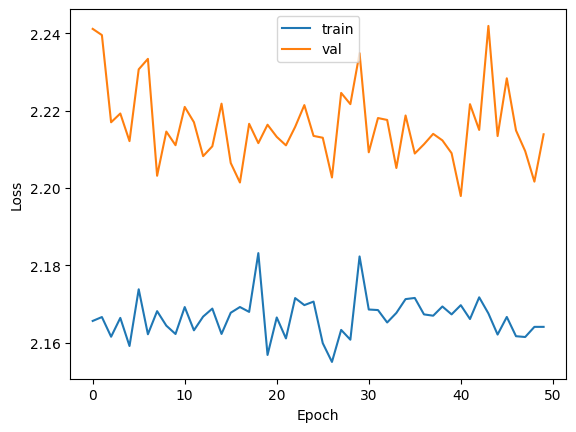

In [62]:
print(history)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [71]:
def report_classification_performance(model, dataloader, device='cpu'):
    model.eval()

    all_preds = []
    all_labels = []
    all_ids = []
    all_masses = []

    with torch.no_grad():
        for i, (batch_data, batch_label) in enumerate(dataloader):
            halo_id = batch_label[2].to(device)
            halo_mass = batch_label[0].to(device)
            batch_label = batch_label[1].to(device)
        

            pred_class = model(batch_data.to(device))

            all_preds.append(pred_class)
            all_labels.append(batch_label)
            all_masses.append(halo_mass)
            all_ids.append(halo_id)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_masses = torch.cat(all_masses)
    all_ids = torch.cat(all_ids)


    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    all_ids = all_ids.cpu().numpy()
    all_masses = all_masses.cpu().numpy()


    pred_labels = np.argmax(all_preds, axis=1)

    results_df = pd.DataFrame({'id':all_ids, 'mass':all_masses, 'true_class': all_labels, 'pred_class': pred_labels})

    return results_df

result_df = report_classification_performance(classification_model, val_loader, device=device)

pd.crosstab(result_df['true_class'], result_df['pred_class'])


pred_class,0,1,5,6,8
true_class,,,,,
0,9,1526,224,0,0
1,1,23,811,0,0
2,0,0,391,1,0
3,0,0,172,3,0
4,0,0,75,4,0
5,0,0,30,4,5
6,0,0,10,4,7
7,0,0,0,3,4
8,0,0,0,0,1


In [72]:
result_df

,id,mass,true_class,pred_class
0,590866,12.572696,4,5
1,944742,11.060492,0,1
2,766883,11.830979,2,5
3,629299,12.445960,3,5
4,932593,11.118659,0,1
...,...,...,...,...
3304,892712,11.039197,0,1
3305,363145,13.384031,6,6
3306,829323,11.506316,1,5
3307,856191,11.436975,1,5


---

In [73]:
import cProfile, pstats
pr = cProfile.Profile()
pr.enable()

n_epochs = 5

history = classification_train(n_epochs,
                       classification_model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=train_loader,
                        dataloader_val=val_loader,
                        device=device)



pr.disable()
pr.create_stats()
s = pstats.Stats(pr)
#s.sort_stats('time')
s.sort_stats('cumtime')
s.print_stats()

100%|██████████| 5/5 [00:35<00:00,  7.10s/it, loss=2.21, val_loss=2.19]


         18768912 function calls (18631932 primitive calls) in 35.495 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   35.495   11.832 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        3    0.000    0.000   35.495   11.832 {built-in method builtins.exec}
        1    0.000    0.000   35.495   35.495 <ipython-input-73-20cd4b0b07c4>:1(<cell line: 7>)
        1    0.000    0.000   35.495   35.495 <ipython-input-56-03bcf372d135>:98(classification_train)
        5    0.094    0.019   35.462    7.092 <ipython-input-56-03bcf372d135>:34(classification_train_step)
      145    0.003    0.000   26.872    0.185 /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:626(__next__)
      145    0.026    0.000   26.853    0.185 /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:673(_next_data)
      135    0.001    0.000   26.7